In [1]:
# Write a script that plots torque, developed power and line current versus rotor speed 
# for a three-phase induction motor given a set of parameters.

import numpy as np
import matplotlib.pyplot as plt

# for testing, set numpy precision to 2 decimal points
np.set_printoptions(precision=2)

In [2]:
# define functions
# find closest value in array
def find_nearest(x,value):
    idx = np.abs(x[np.isfinite(x)] - value).argmin()
    #print(f"idx for {value} is {idx}")
    return idx

# calculate parallel impedances
def parallel(a,b):
    return 1/(1/a + 1/b)

def findSlip(n_sync,n_m):
    return (n_sync + 0.0001 - n_m) / n_sync

def findZth(R1,X1,Xm):
    a = (R1 + X1*1j)
    b = Xm*1j
    return parallel(a,b)

def findVth(R1,X1,Xm,V):
    div = (Xm*1j) / (Xm*1j + R1 + X1*1j)
    return V*div

def findI2(R1,R2,X1,X2,Xm,V,n_sync,n_m):
    Vth = findVth(R1,X1,Xm,V)
    Zth = findZth(R1,X1,Xm)
    s = findSlip(n_sync,n_m)
    return Vth / (Zth + X2*1j + R2/s)

def findI1(I2,R2,X2,Xm,n_sync,n_m):
    s = findSlip(n_sync,n_m)
    div = (R2/s + 1j*(X2 + Xm)) / (1j*Xm)
    return I2 * div

In [3]:
# define variables
# number of points to calculate
N = 200
# given variables
R1 = .550
R2 = 1.7
X1 = 1.8
X2 = 2.1
Xm = 200
V_line = 208
fe = 60
poles = 4
HPrated = 1.5

# rated variables
Prated = 746 * HPrated
n_sync = 120 * fe / poles
w_sync = n_sync / 60 * 2*np.pi
V = V_line / np.sqrt(3)

# speed axis
n_m = np.linspace(0.01,n_sync,N)
w_m = n_m / 60 * 2*np.pi
# slip is a range between 1 (locked rotor) and 0 (synch speed)
s = findSlip(n_sync,n_m)

# calculate outputs
I2 = findI2(R1,R2,X1,X2,Xm,V,n_sync,n_m)
I1 = findI1(I2,R2,X2,Xm,n_sync,n_m)
torque_ind = (3 * abs(np.square(I2)) * R2) / (s * w_sync)
Pconv = w_m * torque_ind

In [4]:
# find point of rated power
idx_Prated = N//2 + find_nearest(Pconv[N//2:],Prated)
print(f"rated power: {Prated} W")
#print(f"power at found index: {Pconv[idx_Prated]} W")

rated power: 1119.0 W


In [5]:
# find specific values
# starting line current
st_ln_current = abs(I1[0])
print(f"starting line current:  {st_ln_current:.2f} A")
# no load line current
#I2_nl = findI2(R1,0,X1,X2,Xm,V,n_sync,0)
#nl_ln_current = findI1(I2_nl,0,X2,Xm,n_sync,0)
nl_ln_current = abs(V / (R1 + 1j*X1 + 1j*Xm))
print(f"no-load line current:   {abs(nl_ln_current):.2f} A")
# full-load line current
fl_ln_current = I1[idx_Prated]
print(f"full-load line current: {abs(fl_ln_current):.2f} A")
# locked rotor torque
I2_locked = findI2(R1,R2,X1,X2,Xm,V,n_sync,0)
torque_locked = (3 * abs(I2_locked**2) * R2) / (1 * w_sync)
print(f"locked rotor torque: {torque_locked:.2f} Nm")
# pullout torque
torque_po = np.max(torque_ind)
print(f"pullout torque: {torque_po:.2f} Nm")
# rated torque
torque_rated = torque_ind[idx_Prated]
print(f"rated torque: {torque_rated:.2f} Nm")
# peak power
Ppeak = np.max(Pconv)
print(f"peak power: {Ppeak:.2f} W")
# rated speed
n_rated = n_m[idx_Prated]
print(f"rated speed: {n_rated:.2f} rpm")
# slip at rated speed
s_rated = findSlip(n_sync,n_rated) * 100
print(f"slip at rated speed: {s_rated:.2f} %")

starting line current:  26.82 A
no-load line current:   0.60 A
full-load line current: 3.53 A
locked rotor torque: 19.05 Nm
pullout torque: 25.26 Nm
rated torque: 6.37 Nm
peak power: 3159.34 W
rated speed: 1709.55 rpm
slip at rated speed: 5.03 %


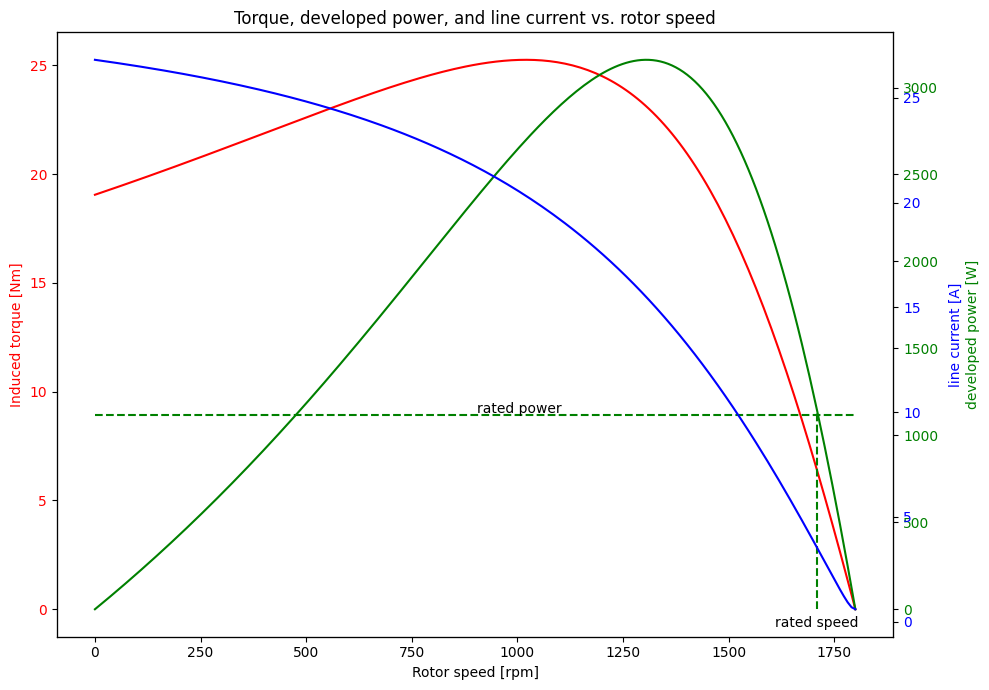

In [6]:
# plot curves
fig, ax = plt.subplots(figsize=(10,7))
ax.set_xlabel('Rotor speed [rpm]')
ax.set_title('Torque, developed power, and line current vs. rotor speed')
# plot induced torque
ax.plot(n_m,torque_ind, color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylabel('Induced torque [Nm]', color='red')
# create more y axes
ax2 = ax.twinx()
ax3 = ax.twinx()
# plot developed power
ax2.plot(n_m,Pconv, color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylabel('developed power [W]', color='green', labelpad=20)
# plot line current
ax3.plot(n_m,abs(I1), color='blue')
ax3.tick_params(axis='y', labelcolor='blue')
ax3.set_ylabel('line current [A]', color='blue', labelpad=20)
# rated load line
ax2.vlines(n_m[idx_Prated],0,Pconv[idx_Prated],color='green',linestyles='dashed',label='rated speed')
ax2.text(n_m[idx_Prated]-100,-100,"rated speed")
ax2.hlines(Prated,0,n_m[N-1],color='green',linestyles='dashed',label='rated power')
ax2.text(n_m[N//2],Prated+10,"rated power")

# shift tick marks
ax2.set_yticks(range(0,int(np.max(Pconv)),500))

plt.tight_layout()
plt.show()